In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, initializers, Sequential, datasets, models, layers, regularizers
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import os
import json
import re
from PIL import Image
import pickle

keras.utils.set_random_seed(171)

# 1. Setup and Load Data

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"ecs171gp6","key":"bd53b6c8c547692f6356796b2b577616"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d crowww/a-large-scale-fish-dataset
!mkdir dataset
!unzip -qq a-large-scale-fish-dataset.zip -d dataset
# !sudo rm -rf ./dataset

100% 3.24G/3.24G [00:30<00:00, 118MB/s]
100% 3.24G/3.24G [00:30<00:00, 115MB/s]


- No further augmentation needed (since the dataset have been pre processed)

In [ ]:
# Load the data from the dataset into the DataLoader object (Essential) (Evans)
def dataLoading():
  all_path = []  # To include the full path of each image

  # List of files to exclude
  exclude_files = ['Segmentation_example_script.m', 'README.txt', 'license.txt']

  # Specify the path to the directory containing subdirectories with image data
  fish_path = r'dataset/Fish_Dataset/Fish_Dataset'

  subdirectories = [subdir for subdir in os.listdir(fish_path)
                              if os.path.isdir(os.path.join(fish_path, subdir))]

  for img_path in subdirectories:
      if img_path in exclude_files:
          continue

      img_subdirectory = os.path.join(fish_path, img_path)

      # Use TensorFlow's file operations to get
      # a list of image files in the subdirectory
      all_data = tf.data.Dataset.list_files(
                                os.path.join(img_subdirectory, img_path, "*.*")
                                )
      # Decode to string
      all_data = [path.decode('utf-8') for path in all_data.as_numpy_iterator()]

      # To add full path of each image in all_path list mentioned before
      all_path.extend(all_data)

  images_df=pd.DataFrame({'Filepath':all_path})
  images_df['Label']=images_df['Filepath'].apply(lambda x : x.split('/')[-2])
  pd.options.display.max_colwidth = 200

  #shuffling and reset index
  # images_df = images_df.sample(frac=1).reset_index(drop = True)
  images_df_shuffled = images_df.sample(frac=1).reset_index(drop = True)
  # Display basic statistics
  print(images_df_shuffled['Label'].value_counts())

  # Visualize sample images
  plt.figure(figsize=(12, 12))
  for i in range(25):
      image_path = images_df_shuffled['Filepath'][i]
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.subplot(5, 5, i + 1)
      plt.imshow(image)
      plt.title(f"{images_df_shuffled['Label'][i]}")
      plt.axis("off")
  plt.show()

  return images_df

CNN structure (70% data)  
Validation (20% data)  
Testing (10% data)

In [ ]:
def prepareData(data):
    training_df,testing_df = train_test_split(data,test_size=0.1, shuffle=True, random_state=42)

    training_generator=ImageDataGenerator(
                                  validation_split=0.2,
                                  )
    testing_generator=ImageDataGenerator()
    training_images = training_generator.flow_from_dataframe(
                                                    dataframe=training_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    class_mode='categorical',
                                                    target_size=(400, 267),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    shuffle=False,
                                                    subset='training'
                                                    )

    validation_images=training_generator.flow_from_dataframe(
                                                    dataframe=training_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    class_mode='categorical',
                                                    target_size=(400,267),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    shuffle=False,
                                                    subset='validation'
                                                    )

    testing_images=testing_generator.flow_from_dataframe(
                                                    dataframe=testing_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    class_mode='categorical',
                                                    target_size=(400,267),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    shuffle=False,
                                                    )
    return (training_images, validation_images, testing_images), (training_df, testing_df)

In [ ]:
def train_test_model(model, images, modelName, epoch=30, stopAfter=5):
    history = 0
    training_images, validation_images, testing_images = images

    # Callbacks to help training
    checkpoint_path = "best_"+ modelName + ".h5"
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=0,factor=0.1)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=stopAfter, restore_best_weights=True)

    if os.path.exists("/content/best_"+ modelName + ".h5"):
        print("File exists.")
    else:
        history = model.fit(
        training_images,
        epochs=epoch,
        validation_data=validation_images,
        callbacks=[checkpoint, early_stopping, reduce_lr]  # Add the ModelCheckpoint callback
        )
        # Print training loss at each epoch
        for epoch, loss in enumerate(history.history['loss'], 1):
            print(f'Epoch {epoch}, Training Loss: {loss}')

        print(f'Training Loss: {history.history["loss"][-1]}')
        print(f'Validation Loss: {history.history["val_loss"][-1]}')
        print(f'Training Accuracy: {history.history["accuracy"][-1]}')
        print(f'Validation Accuracy: {history.history["val_accuracy"][-1]}')

    # Load the best model
    best_model = load_model(checkpoint_path)

    # Evaluate the best model on the testing set
    test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(testing_images)

    # Print final metrics
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test Precision: {test_precision}')
    print(f'Test Recall: {test_recall}')
    return history

# Basic CNN Model Definition

In [ ]:
# Build our simple CNN model
def build_model(dropout1=0.2, dropout2=0.2, dropout3=0.3, l2param=0.0005, learningrate=0.001):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (400, 267, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout1))

    model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout2))

    model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(l2param)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout3))
    model.add(layers.Dense(9, activation='softmax'))

    model.compile(optimizer = Adam(learning_rate=learningrate),
                  loss='categorical_crossentropy',
                  metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Utility Functions

In [ ]:
def plotHistory(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(history.history['recall'], label='Training Recall')
  plt.plot(history.history['val_recall'], label='Validation Recall')
  plt.title('Training and Validation Recall Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.legend()
  plt.show()

  plt.plot(history.history['precision'], label='Training Precision')
  plt.plot(history.history['val_precision'], label='Validation Precision')
  plt.title('Training and Validation Precision Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

def classificationReport(train_test_df, images, model):
  training_df, testing_df = train_test_df
  training_images, validation_images, testing_images = images
  prediction=model.predict(testing_images)
  prediction=np.argmax(prediction,axis=1)

  labels = dict((v,k) for k,v in testing_images.class_indices.items())
  prediction = [labels[k] for k in prediction]
  y_true = testing_df['Label'].values

  print(classification_report(y_true,prediction))
  return y_true, prediction

def confusionMatrix(y_true, prediction):
  cm=confusion_matrix(y_true,prediction)
  plt.figure(figsize=(15,5))
  sns.heatmap(cm , annot=True,cmap='crest', linewidths=0.5)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion matrix of 9 fish classes')
  plt.show()

def remove_numeric_suffix(input_string):
    pattern = re.compile(r'_(\d+)$')
    result = re.sub(pattern, '', input_string)
    return result

# ResNet-50 Model

In [ ]:
def resnet50(inputShape = (400, 267, 3)):
    inputs = tf.keras.layers.Input(inputShape)

    base_model = tf.keras.applications.resnet50.ResNet50(
        input_shape=(400, 267, 3),
        weights='imagenet',
        pooling='avg',
        include_top=False
        )

    base_model.trainable = False

    x = base_model(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs =  layers.Dense(9, activation='softmax')(x)

    model = tf.keras.models.Model(inputs, outputs)

    model.compile(optimizer = Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# VGG16 Model

In [ ]:
def vgg16(inputShape = (400, 267, 3)):
    inputs = tf.keras.layers.Input(inputShape)

    base_model = tf.keras.applications.VGG16(
        input_shape=(400, 267, 3),
        weights='imagenet',
        pooling='avg',
        include_top=False
        )

    base_model.trainable = False

    x = base_model(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs =  layers.Dense(9, activation='softmax')(x)

    model = tf.keras.models.Model(inputs, outputs)

    model.compile(optimizer = Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Running Our Basic CNN Model

Hourse Mackerel       1000
Sea Bass              1000
Red Mullet            1000
Gilt-Head Bream       1000
Striped Red Mullet    1000
Trout                 1000
Shrimp                1000
Black Sea Sprat       1000
Red Sea Bream         1000
Name: Label, dtype: int64


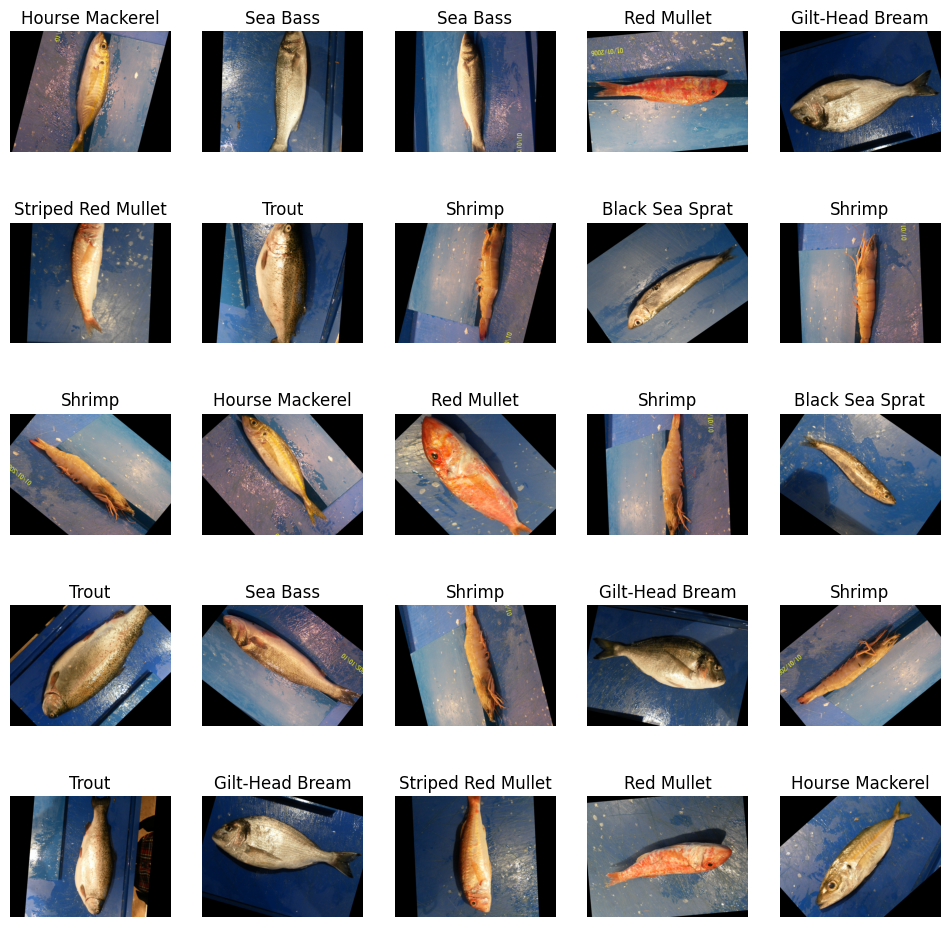

In [ ]:
data = dataLoading()

In [ ]:
images, train_test_df = prepareData(data)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [ ]:
model = build_model(dropout1=0.2, dropout2=0.2, dropout3=0.3, l2param=0.0005, learningrate=0.001)
history = train_test_model(model, images, "CNN", epoch=30, stopAfter=5)

# weird case with precision and recall
if history != 0:
  for key in list(history.history.keys()):
    new_key = remove_numeric_suffix(key)
    history.history[new_key] = history.history.pop(key)

Epoch 1/30
203/203 [==============================] - ETA: 0s - loss: 1.2179 - accuracy: 0.6673 - precision: 0.7892 - recall: 0.5338
Epoch 1: val_accuracy improved from -inf to 0.28951, saving model to best_CNN.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - 142s 580ms/step - loss: 1.2179 - accuracy: 0.6673 - precision: 0.7892 - recall: 0.5338 - val_loss: 2.2313 - val_accuracy: 0.2895 - val_precision: 0.2937 - val_recall: 0.2426 - lr: 0.0010
Epoch 2/30
203/203 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.9340 - precision: 0.9585 - recall: 0.9019
Epoch 2: val_accuracy improved from 0.28951 to 0.80062, saving model to best_CNN.h5
203/203 [==============================] - 115s 566ms/step - loss: 0.4858 - accuracy: 0.9340 - precision: 0.9585 - recall: 0.9019 - val_loss: 0.8169 - val_accuracy: 0.8006 - val_precision: 0.8539 - val_recall: 0.7574 - lr: 0.0010
Epoch 3/30
203/203 [==============================] - ETA: 0s - loss: 0.2980 - accuracy: 0.9852 - precision: 0.9892 - recall: 0.9772
Epoch 3: val_accuracy improved from 0.80062 to 0.86790, saving model to best_CNN.h5
203/203 [==============================] - 113s 556ms/step - loss: 0.2980 - accuracy: 0.9852 - precision: 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 265, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 398, 265, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 132, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 199, 132, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 130, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 197, 130, 64)      2

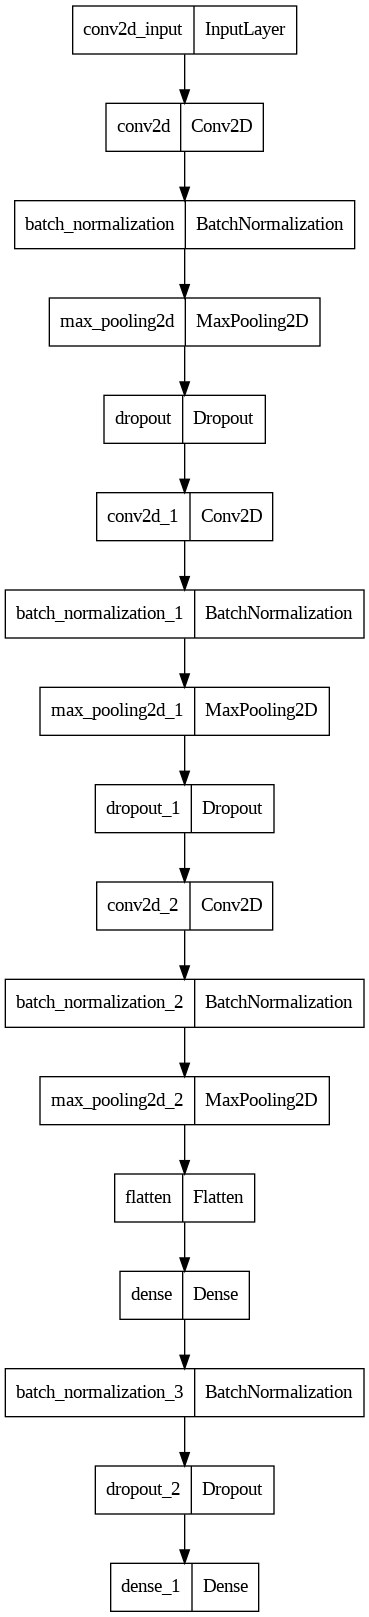

In [ ]:
tf.keras.utils.plot_model(model)

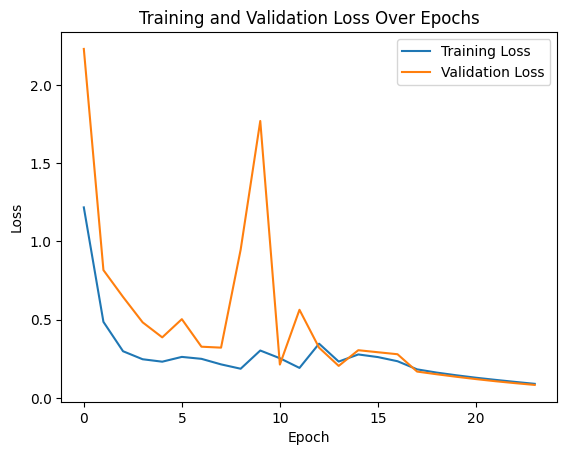

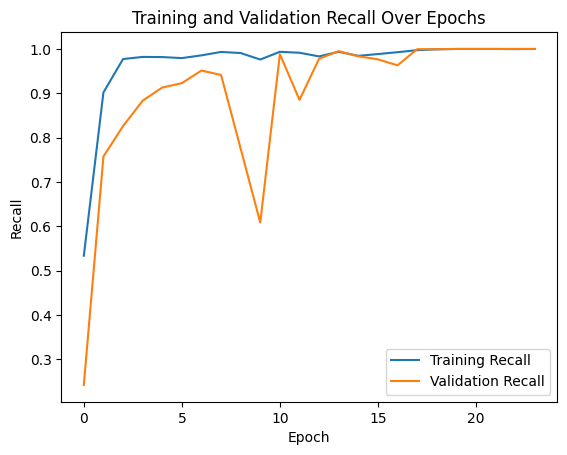

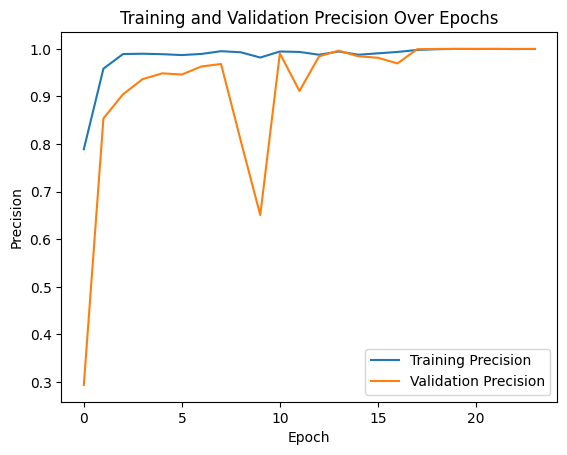

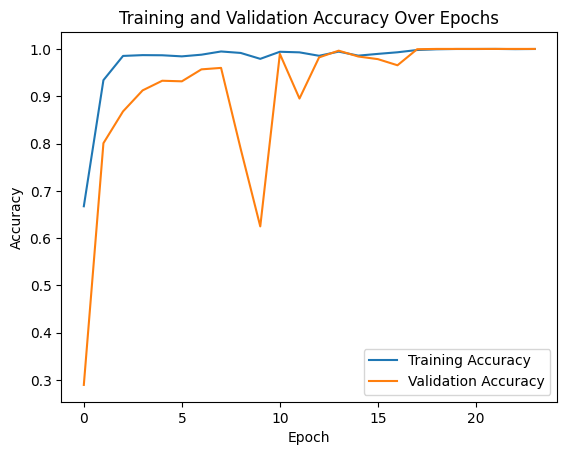

In [ ]:
plotHistory(history)

In [ ]:
y_true, prediction = classificationReport(train_test_df, images, model)

29/29 [==============================] - 10s 336ms/step
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00        91
   Gilt-Head Bream       1.00      1.00      1.00       121
   Hourse Mackerel       1.00      1.00      1.00        99
        Red Mullet       1.00      1.00      1.00       108
     Red Sea Bream       1.00      1.00      1.00       103
          Sea Bass       1.00      1.00      1.00       100
            Shrimp       1.00      1.00      1.00        96
Striped Red Mullet       1.00      1.00      1.00        79
             Trout       1.00      1.00      1.00       103

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



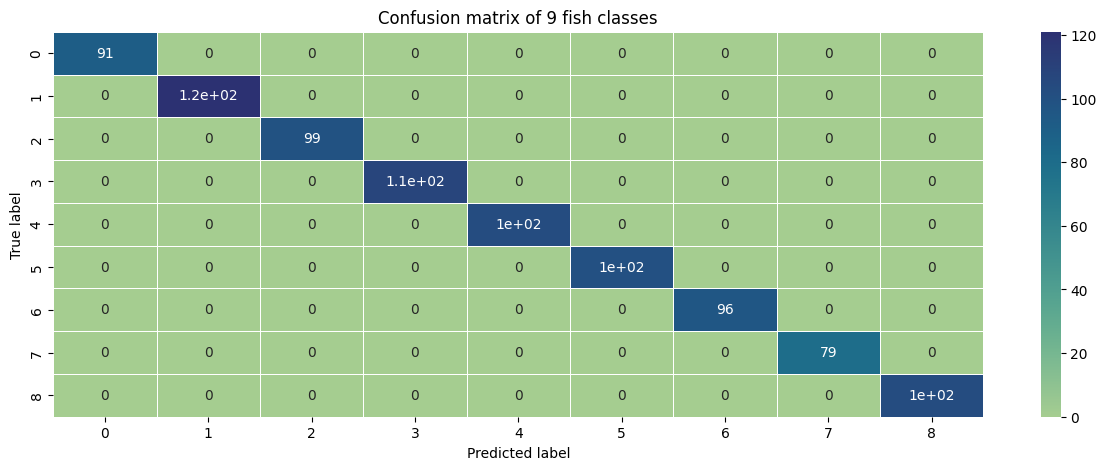

In [ ]:
confusionMatrix(y_true, prediction)

# ResNet-50 Comparison

In [ ]:
modelResnet = resnet50()
historyResnet = train_test_model(modelResnet, images, "ResNet50", epoch=15, stopAfter=5)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/15
203/203 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.9242 - precision: 0.9769 - recall: 0.8687
Epoch 1: val_accuracy improved from -inf to 0.98951, saving model to best_ResNet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - 137s 590ms/step - loss: 0.3161 - accuracy: 0.9242 - precision: 0.9769 - recall: 0.8687 - val_loss: 0.0807 - val_accuracy: 0.9895 - val_precision: 0.9938 - val_recall: 0.9846 - lr: 0.0010
Epoch 2/15
203/203 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9966 - precision: 0.9978 - recall: 0.9949
Epoch 2: val_accuracy improved from 0.98951 to 0.99198, saving model to best_ResNet50.h5
203/203 [==============================] - 111s 548ms/step - loss: 0.0459 - accuracy: 0.9966 - precision: 0.9978 - recall: 0.9949 - val_loss: 0.0530 - val_accuracy: 0.9920 - val_precision: 0.9932 - val_recall: 0.9883 - lr: 0.0010
Epoch 3/15
203/203 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9992
Epoch 3: val_accuracy improved from 0.99198 to 0.99691, saving model to best_ResNet50.h5
203/203 [==============================] - 109s 538ms/step - loss: 0.0199 - accuracy: 0.9994 - p

In [ ]:
# weird case with precision and recall
if historyResnet != 0:
  for key in list(historyResnet.history.keys()):
    new_key = remove_numeric_suffix(key)
    historyResnet.history[new_key] = historyResnet.history.pop(key)

In [ ]:
modelResnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 267, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 585       
                                                             

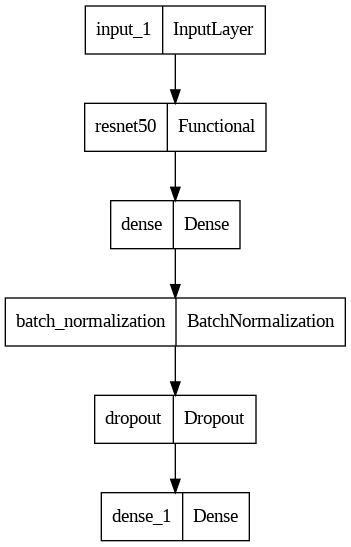

In [ ]:
tf.keras.utils.plot_model(modelResnet)

# Annotated ResNet-50 Architecture
[[Image Source](https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758)]

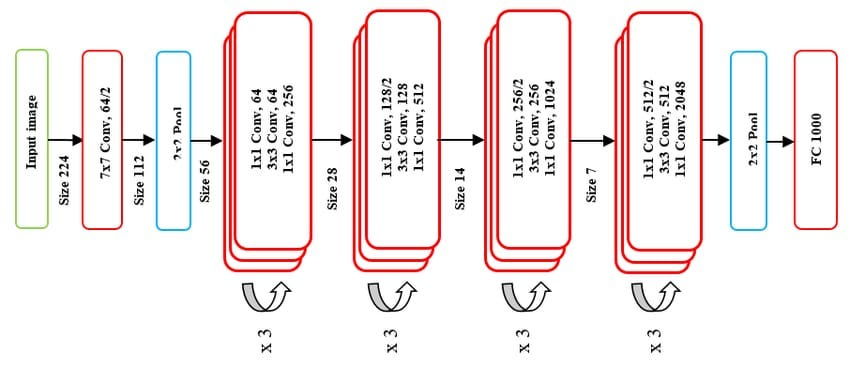

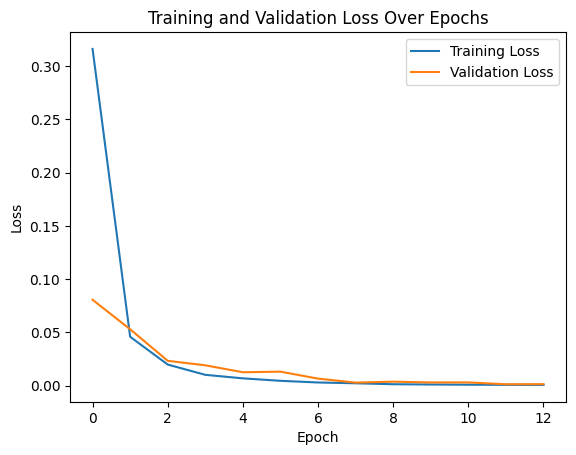

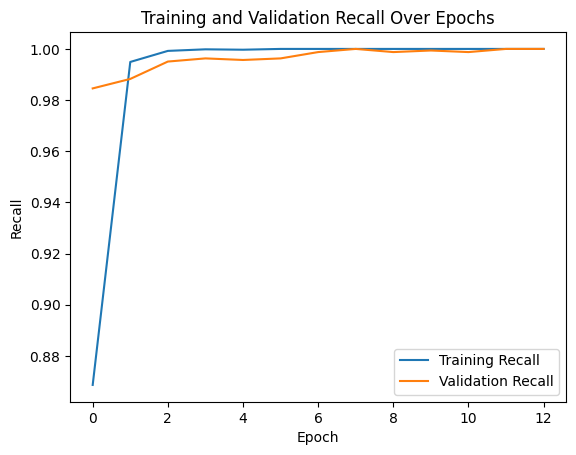

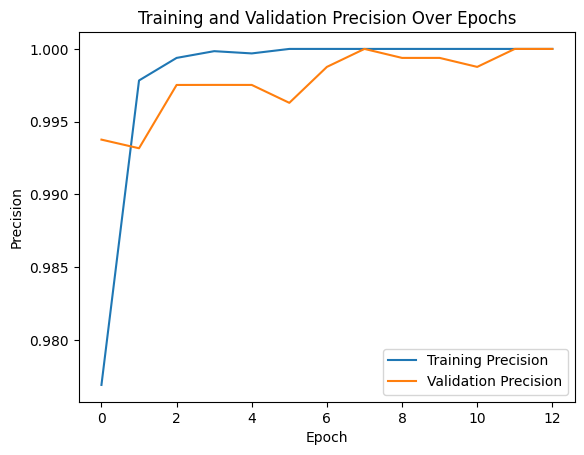

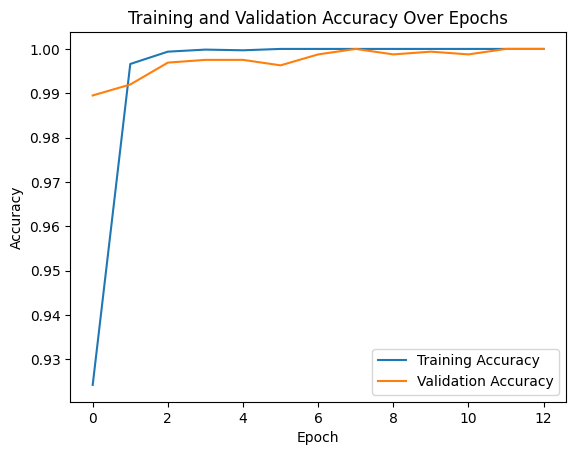

In [ ]:
plotHistory(historyResnet)

In [ ]:
y_trueResnet, predictionResnet = classificationReport(train_test_df, images, modelResnet)

29/29 [==============================] - 13s 412ms/step
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       103
   Gilt-Head Bream       1.00      1.00      1.00       100
   Hourse Mackerel       1.00      1.00      1.00        91
        Red Mullet       1.00      1.00      1.00        96
     Red Sea Bream       1.00      1.00      1.00       108
          Sea Bass       1.00      1.00      1.00        99
            Shrimp       1.00      1.00      1.00       121
Striped Red Mullet       1.00      1.00      1.00       103
             Trout       1.00      1.00      1.00        79

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



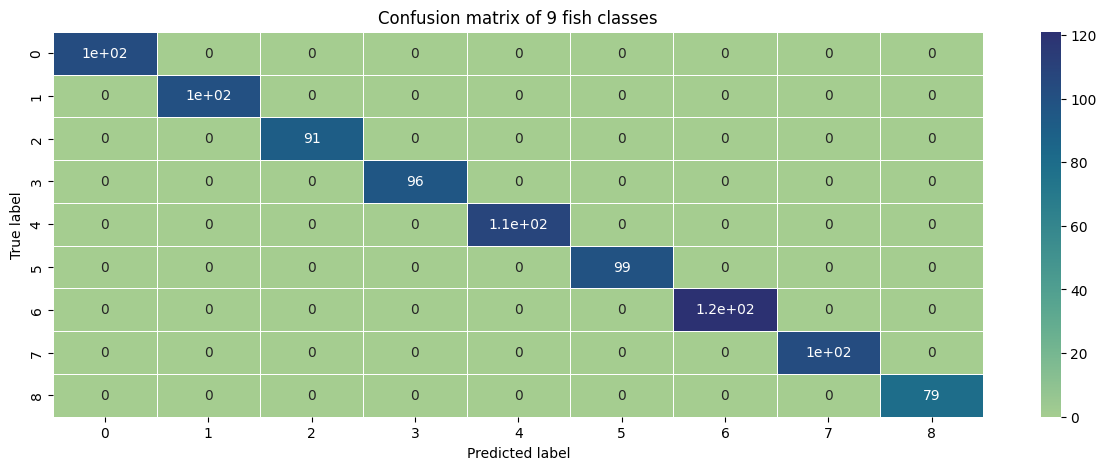

In [ ]:
confusionMatrix(y_trueResnet, predictionResnet)

# VGG16 Model Comparison


In [ ]:
modelVGG = vgg16()
historyVGG = train_test_model(modelVGG, images, "VGG16", epoch=15, stopAfter=5)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/15
203/203 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.8241 - precision_1: 0.9397 - recall_1: 0.7048
Epoch 1: val_accuracy improved from -inf to 0.96420, saving model to best_VGG16.h5
203/203 [==============================] - 127s 584ms/step - loss: 0.6238 - accuracy: 0.8241 - precision_1: 0.9397 - recall_1: 0.7048 - val_loss: 0.1511 - val_accuracy: 0.9642 - val_precision_1: 0.9782 - val_recall_1: 0.9420 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/15
203/203 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9813 - precision_1: 0.9874 - recall_1: 0.9701
Epoch 2: val_accuracy improved from 0.96420 to 0.98951, saving model to best_VGG16.h5
203/203 [==============================] - 110s 539ms/step - loss: 0.1169 - accuracy: 0.9813 - precision_1: 0.9874 - recall_1: 0.9701 - val_loss: 0.0656 - val_accuracy: 0.9895 - val_precision_1: 0.9907 - val_recall_1: 0.9852 - lr: 0.0010
Epoch 3/15
203/203 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9915 - precision_1: 0.9941 - recall_1: 0.9881
Epoch 3: val_accuracy improved from 0.98951 to 0.99321, saving model to best_VGG16.h5
203/203 [==============================] - 128s 629ms/step - loss: 0.0576 - accuracy: 0.9915 - precision_1: 0.9941 - recall_1: 0.9881 - val_loss: 0.0450 - val_accuracy: 0.9932 - val_precision_1: 0.9938 - val_recall_1: 0.9914 - lr: 0.0010
Epoch 4/15
203/203 [==============================] - ETA: 0s - loss: 0.0311 -

In [ ]:
# weird case with precision and recall
if historyVGG != 0:
  for key in list(historyVGG.history.keys()):
    new_key = remove_numeric_suffix(key)
    historyVGG.history[new_key] = historyVGG.history.pop(key)

In [ ]:
modelVGG.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 400, 267, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 9)                 585       
                                                           

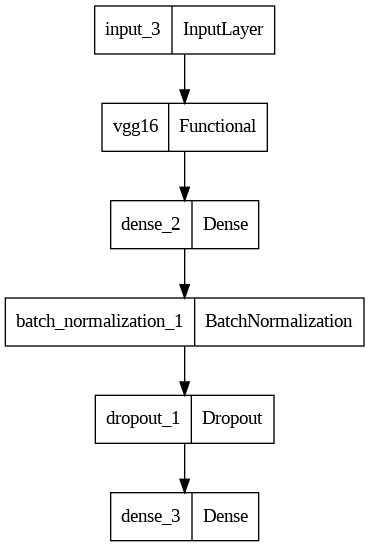

In [ ]:
tf.keras.utils.plot_model(modelVGG)

# VGG-16 Model Architecture
[[Image Source](https://pub.towardsai.net/the-architecture-and-implementation-of-vgg-16-b050e5a5920b)]

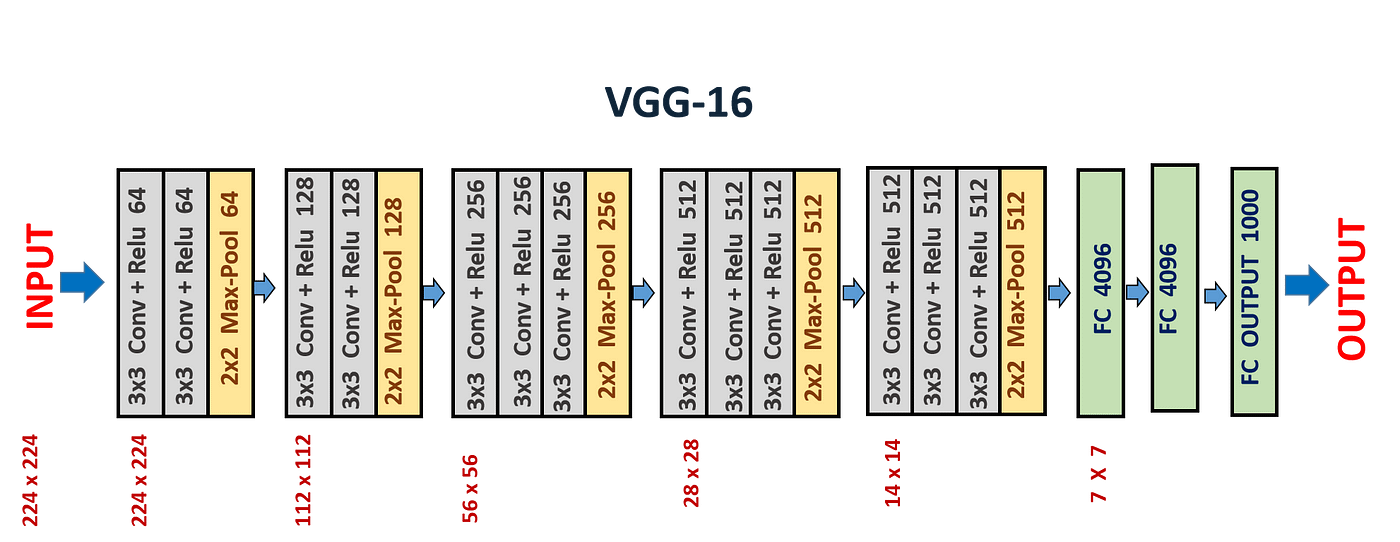

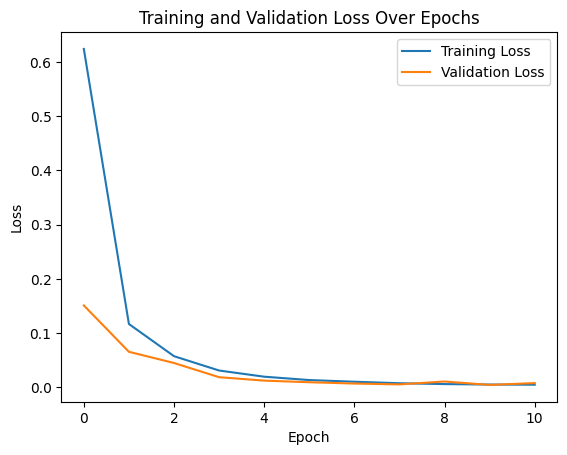

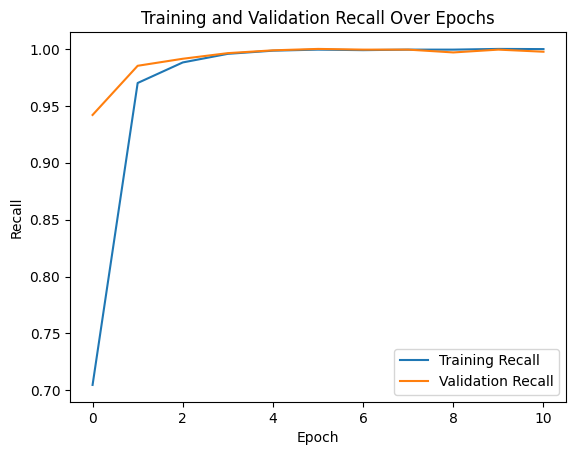

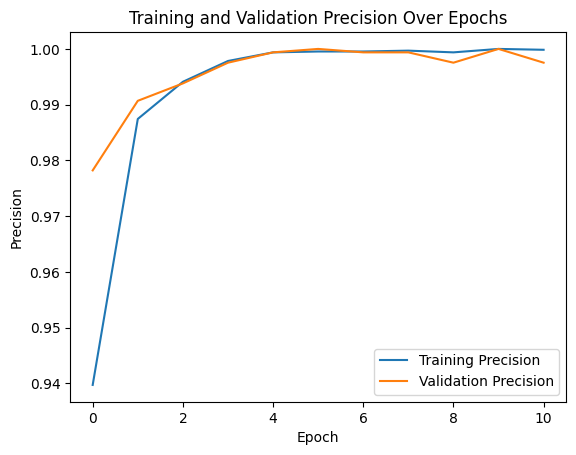

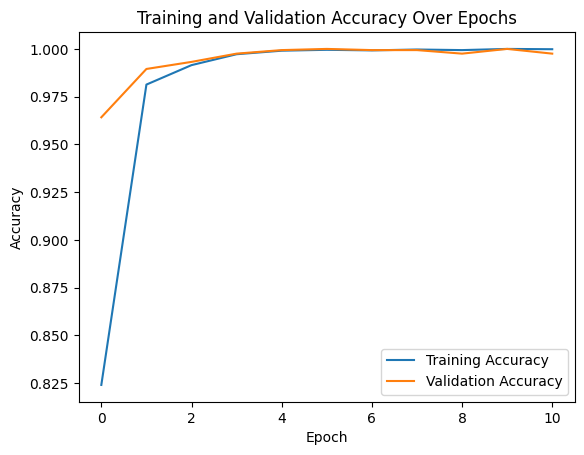

In [ ]:
plotHistory(historyVGG)

In [ ]:
y_trueVGG, predictionVGG = classificationReport(train_test_df, images, modelVGG)

29/29 [==============================] - 13s 447ms/step
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       103
   Gilt-Head Bream       0.99      0.97      0.98       100
   Hourse Mackerel       1.00      1.00      1.00        91
        Red Mullet       1.00      0.99      0.99        96
     Red Sea Bream       0.97      0.99      0.98       108
          Sea Bass       1.00      1.00      1.00        99
            Shrimp       1.00      1.00      1.00       121
Striped Red Mullet       0.99      1.00      1.00       103
             Trout       1.00      1.00      1.00        79

          accuracy                           0.99       900
         macro avg       0.99      0.99      0.99       900
      weighted avg       0.99      0.99      0.99       900



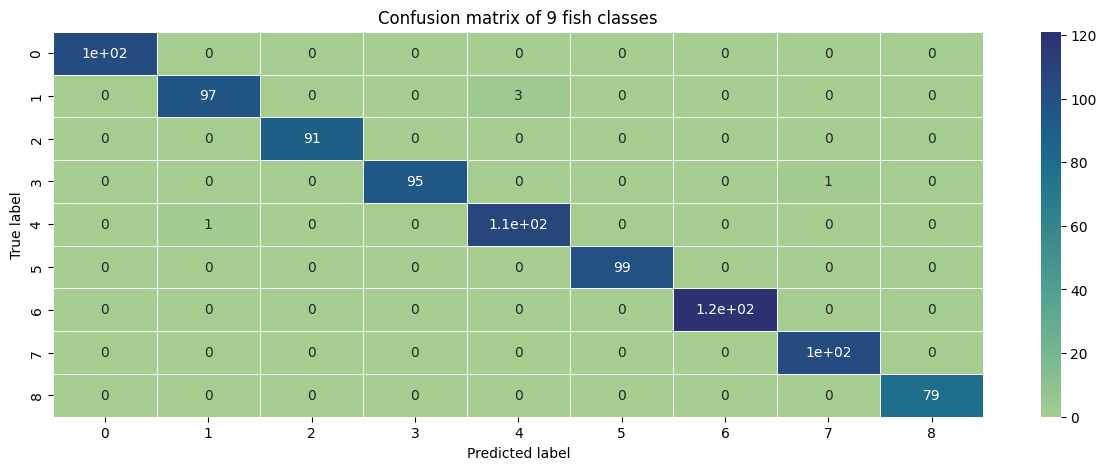

In [ ]:
confusionMatrix(y_trueVGG, predictionVGG)